## Imports

In [427]:
!git clone https://github.com/DanteMillerDS/NASA-Material-Classifier.git
%cd NASA-Material-Classifier
!pip install xgboost
import numpy as np
np.random.seed(1000)
import pandas as pd
import torch.nn.functional as F
from tensorflow.keras.losses import mean_absolute_error
import tensorflow as tf
tf.random.set_seed(1000)
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import scipy.io
from tensorflow.keras.callbacks import ReduceLROnPlateau
import torch.nn as nn
from sklearn.model_selection import train_test_split
import uuid
import torch
from keras.layers import Bidirectional, LSTM, Dense
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Cloning into 'NASA-Material-Classifier'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 162 (delta 1), reused 10 (delta 1), pack-reused 150
Receiving objects: 100% (162/162), 227.45 MiB | 25.55 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Updating files: 100% (65/65), done.
/content/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier


# Preprocessing Meteorite

In [477]:
file_paths = dict()
for i in range(1, 21):
    file_path = [f"data/meteorite/simulated/sau_orientation{i}.txt"]
    file_paths[i] = file_path
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:

            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif "Frequency" in line:
              parts = line.split()
              s_number = parts[3][1:].replace(',', '')
              current_dataset.append(s_number)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)

    data = []
    for index, dataset in enumerate(datasets):
        permittivity_values = dataset[0]
        s_parameter_name = dataset[1]
        df_data = dataset[2:]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        all_combined_data.append(combined_data)
array = []
for combined_data in all_combined_data:
  num_of_data = 4
  dataframes_length = int(len(combined_data)/num_of_data)
  for x in range(dataframes_length):
    concatenated_df = pd.DataFrame()
    for y in range(num_of_data):
      index = y * dataframes_length + x
      concatenated_df = pd.concat([concatenated_df, combined_data[index]], axis=1)
    concatenated_df = concatenated_df.loc[:,~concatenated_df.columns.duplicated()]
    array.append(concatenated_df)
training_dataframe = pd.concat(array, axis=0)

In [478]:
file_paths = dict()
file_paths[0] = ["data/meteorite/actual/mea_sau008_0_orientation.txt"]
file_paths[1] = ["data/meteorite/actual/mea_sau008_90_oreintation.txt"]
file_paths[2] = ["data/meteorite/actual/mea_sau008_180_orientation.txt"]
file_paths[3] = ["data/meteorite/actual/mea_sau008_270_orientation.txt"]

def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:

            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif "Frequency" in line:
              parts = line.split()
              s_number = parts[3][1:].replace(',', '')
              current_dataset.append(s_number)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)

    data = []
    for index, dataset in enumerate(datasets):
        permittivity_values = dataset[0]
        s_parameter_name = dataset[1]
        df_data = dataset[2:]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        all_combined_data.append(combined_data)
array = []
for combined_data in all_combined_data:
  num_of_data = 4
  dataframes_length = int(len(combined_data)/num_of_data)
  for x in range(dataframes_length):
    concatenated_df = pd.DataFrame()
    for y in range(num_of_data):
      index = y * dataframes_length + x
      concatenated_df = pd.concat([concatenated_df, combined_data[index]], axis=1)
    concatenated_df = concatenated_df.loc[:,~concatenated_df.columns.duplicated()]
    array.append(concatenated_df)
testing_dataframe = pd.concat(array, axis=0)

In [479]:
print(training_dataframe.columns)
print(testing_dataframe.columns)

Index(['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID', ' er1',
       ' er11', 'S21_Real', 'S21_Imaginary', 'S12_Real', 'S12_Imaginary',
       'S22_Real', 'S22_Imaginary'],
      dtype='object')
Index(['Frequency', 'S55_Real', 'S55_Imaginary', 'Orientation', 'ID', ' er1',
       ' er11', 'S65_Real', 'S65_Imaginary', 'S56_Real', 'S56_Imaginary',
       'S66_Real', 'S66_Imaginary'],
      dtype='object')


In [480]:
training_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
training_dataframe = training_dataframe[['ID','Frequency', 'Orientation', 'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]
testing_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
testing_dataframe = testing_dataframe[['ID','Frequency', 'Orientation',  'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]

In [481]:
training_dataframe.dropna(inplace=True)
columns = training_dataframe.columns[1:]
training_dataframe[columns] = training_dataframe[columns].apply(pd.to_numeric)
testing_dataframe.dropna(inplace=True)
testing_dataframe[columns] = testing_dataframe[columns].apply(pd.to_numeric)

In [482]:
training_dataframe["Permittivity_Real"] /= 100
testing_dataframe["Permittivity_Real"] /= 100

In [483]:
#testing_dataframe['Permittivity_Imaginary'][testing_dataframe['Permittivity_Imaginary'] > 0.2] = 0.1

In [484]:
training_dataframe = training_dataframe.iloc[:,1:]
testing_dataframe = testing_dataframe.iloc[:,1:]

In [485]:
training_dataframe.head(5)

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,1.0000,1,0.010926,0.001191,0.099731,-0.037289,0.291348,0.942274,0.291348,0.942274,0.103373,-0.025510
1,1.0007,1,0.010926,0.001191,0.098817,-0.039333,0.310043,0.937010,0.310043,0.937010,0.102775,-0.027371
2,1.0014,1,0.010926,0.001191,0.097860,-0.041347,0.328585,0.931373,0.328586,0.931373,0.102141,-0.029213
3,1.0021,1,0.010926,0.001191,0.096864,-0.043331,0.346970,0.925367,0.346970,0.925367,0.101474,-0.031036
4,1.0028,1,0.010926,0.001191,0.095828,-0.045284,0.365189,0.919000,0.365189,0.919000,0.100772,-0.032841


In [486]:
testing_dataframe.head(5)

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,1.0000,0,0.07,0.12,-0.227647,-0.056652,0.938142,-0.238302,0.937925,-0.237764,0.167067,-0.163805
1,1.0007,0,0.07,0.12,-0.225572,-0.061540,0.938475,-0.237830,0.938497,-0.237380,0.163104,-0.166935
2,1.0014,0,0.07,0.12,-0.223387,-0.066383,0.938850,-0.237331,0.938623,-0.236766,0.159039,-0.169771
3,1.0021,0,0.07,0.12,-0.221232,-0.071145,0.939289,-0.236660,0.939100,-0.236155,0.154860,-0.172467
4,1.0028,0,0.07,0.12,-0.218705,-0.076009,0.939595,-0.235950,0.939391,-0.235507,0.150759,-0.175084


In [487]:
training_dataframe.describe()

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
count,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06
mean,1.350000e+00,1.049725e+01,4.945907e-02,4.963151e-02,-2.652006e-03,2.650201e-03,-5.381296e-02,-4.580618e-02,-5.381295e-02,-4.580618e-02,-8.480080e-03,4.908043e-04
std,2.022746e-01,5.766152e+00,2.278568e-02,2.886687e-02,1.036674e-01,1.060097e-01,7.054999e-01,6.794501e-01,7.054999e-01,6.794501e-01,1.009686e-01,1.083329e-01
min,1.000000e+00,1.000000e+00,1.000150e-02,1.707944e-04,-2.180810e-01,-2.549406e-01,-9.986315e-01,-9.962784e-01,-9.986316e-01,-9.962784e-01,-2.144937e-01,-2.509244e-01
25%,1.175000e+00,5.000000e+00,2.930578e-02,2.427854e-02,-8.970921e-02,-8.798371e-02,-7.518066e-01,-7.213721e-01,-7.518066e-01,-7.213721e-01,-9.131249e-02,-9.317510e-02
50%,1.350000e+00,1.000000e+01,4.984754e-02,4.901814e-02,-4.014916e-03,1.737387e-02,-1.561098e-01,-7.297147e-02,-1.561098e-01,-7.297142e-02,-1.472770e-02,1.168782e-02
75%,1.525000e+00,1.500000e+01,6.829293e-02,7.525355e-02,8.478236e-02,8.872819e-02,6.688859e-01,6.198645e-01,6.688859e-01,6.198645e-01,7.616111e-02,9.174016e-02
max,1.700000e+00,2.000000e+01,8.997784e-02,9.994916e-02,2.371261e-01,2.112861e-01,9.993030e-01,9.949554e-01,9.993030e-01,9.949554e-01,2.533520e-01,2.136576e-01


In [488]:
testing_dataframe.describe()

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
count,4004.0000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000
mean,1.3500,1.500000,0.077500,0.430000,-0.008501,0.003331,0.959131,-0.202523,0.959105,-0.202242,0.008399,-0.001808
std,0.2023,1.118174,0.004331,0.337236,0.126175,0.122927,0.004006,0.013707,0.004028,0.013621,0.124165,0.124577
min,1.0000,0.000000,0.070000,0.120000,-0.229152,-0.201646,0.938142,-0.241066,0.937925,-0.240152,-0.185532,-0.211750
25%,1.1750,0.750000,0.077500,0.255000,-0.130663,-0.112173,0.957734,-0.210479,0.957669,-0.210197,-0.115633,-0.119994
50%,1.3500,1.500000,0.080000,0.300000,-0.013226,0.008739,0.960785,-0.200370,0.960799,-0.200090,0.020150,0.001122
75%,1.5250,2.250000,0.080000,0.475000,0.116752,0.121954,0.961649,-0.191734,0.961592,-0.191449,0.128447,0.119894
max,1.7000,3.000000,0.080000,1.000000,0.183352,0.187130,0.963593,-0.181735,0.963461,-0.181764,0.192772,0.184867


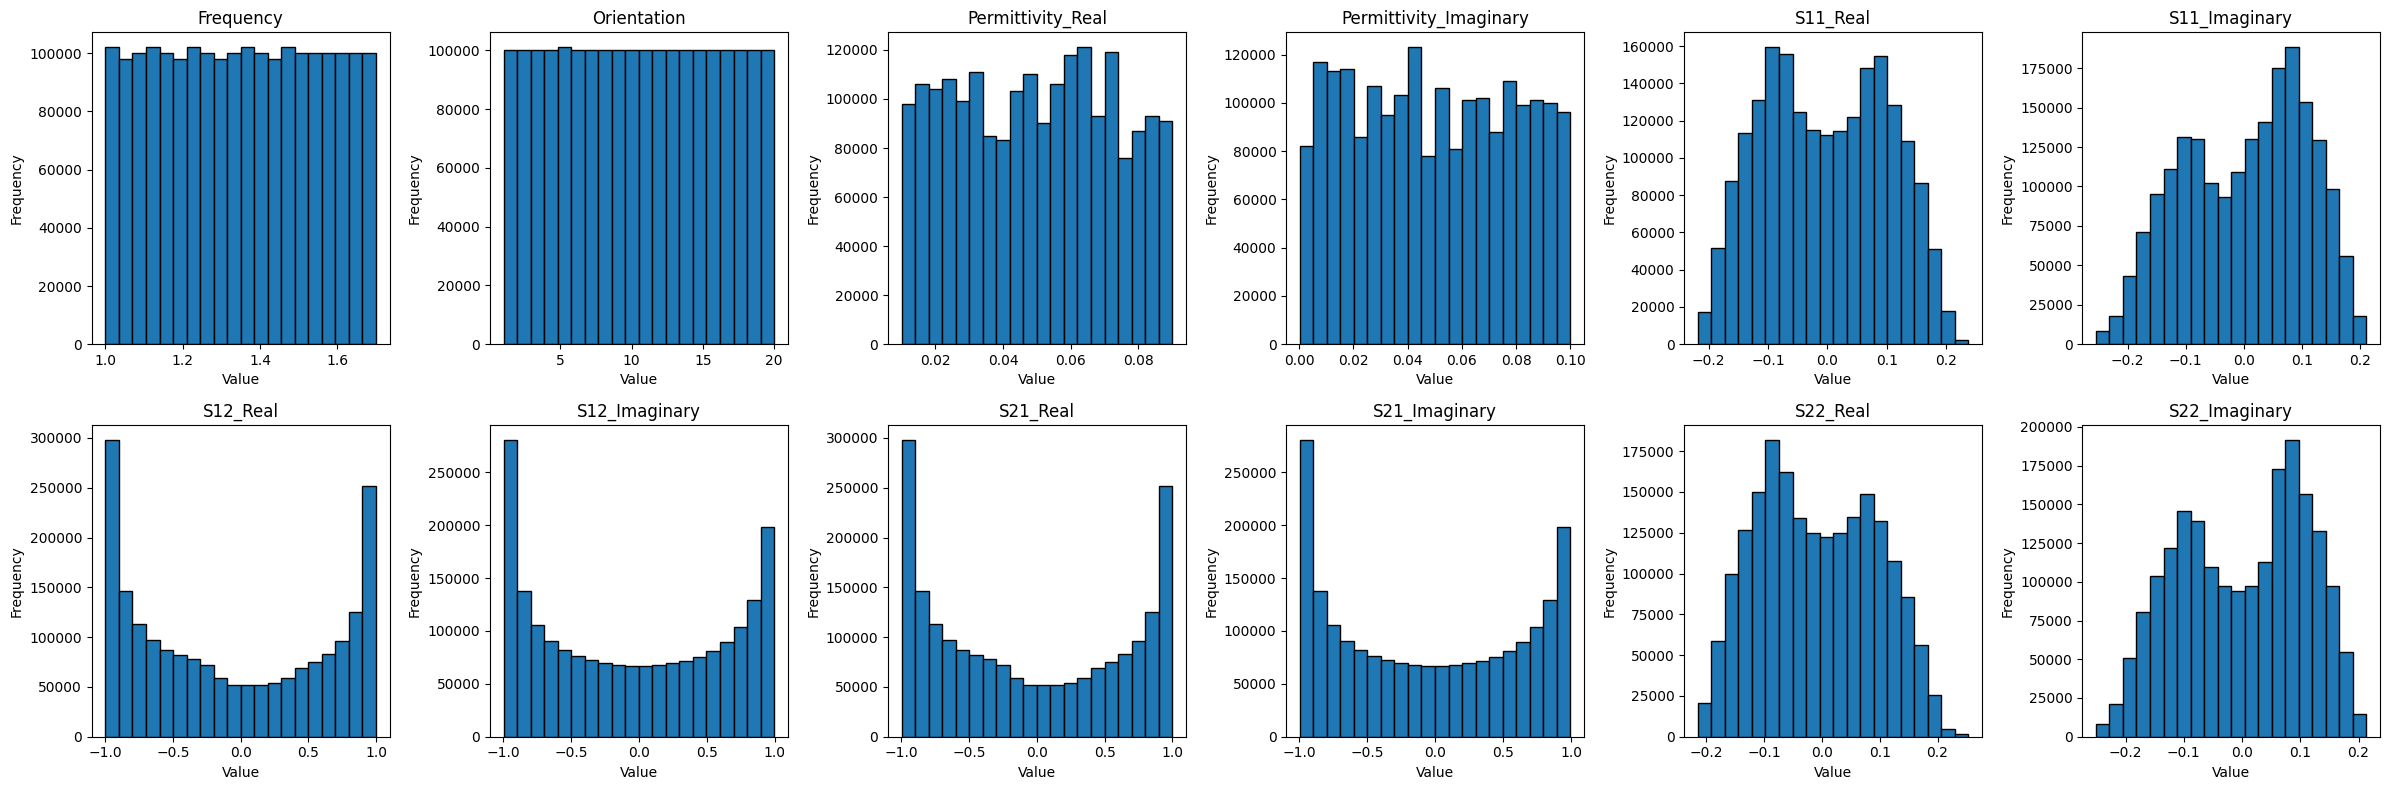

In [489]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

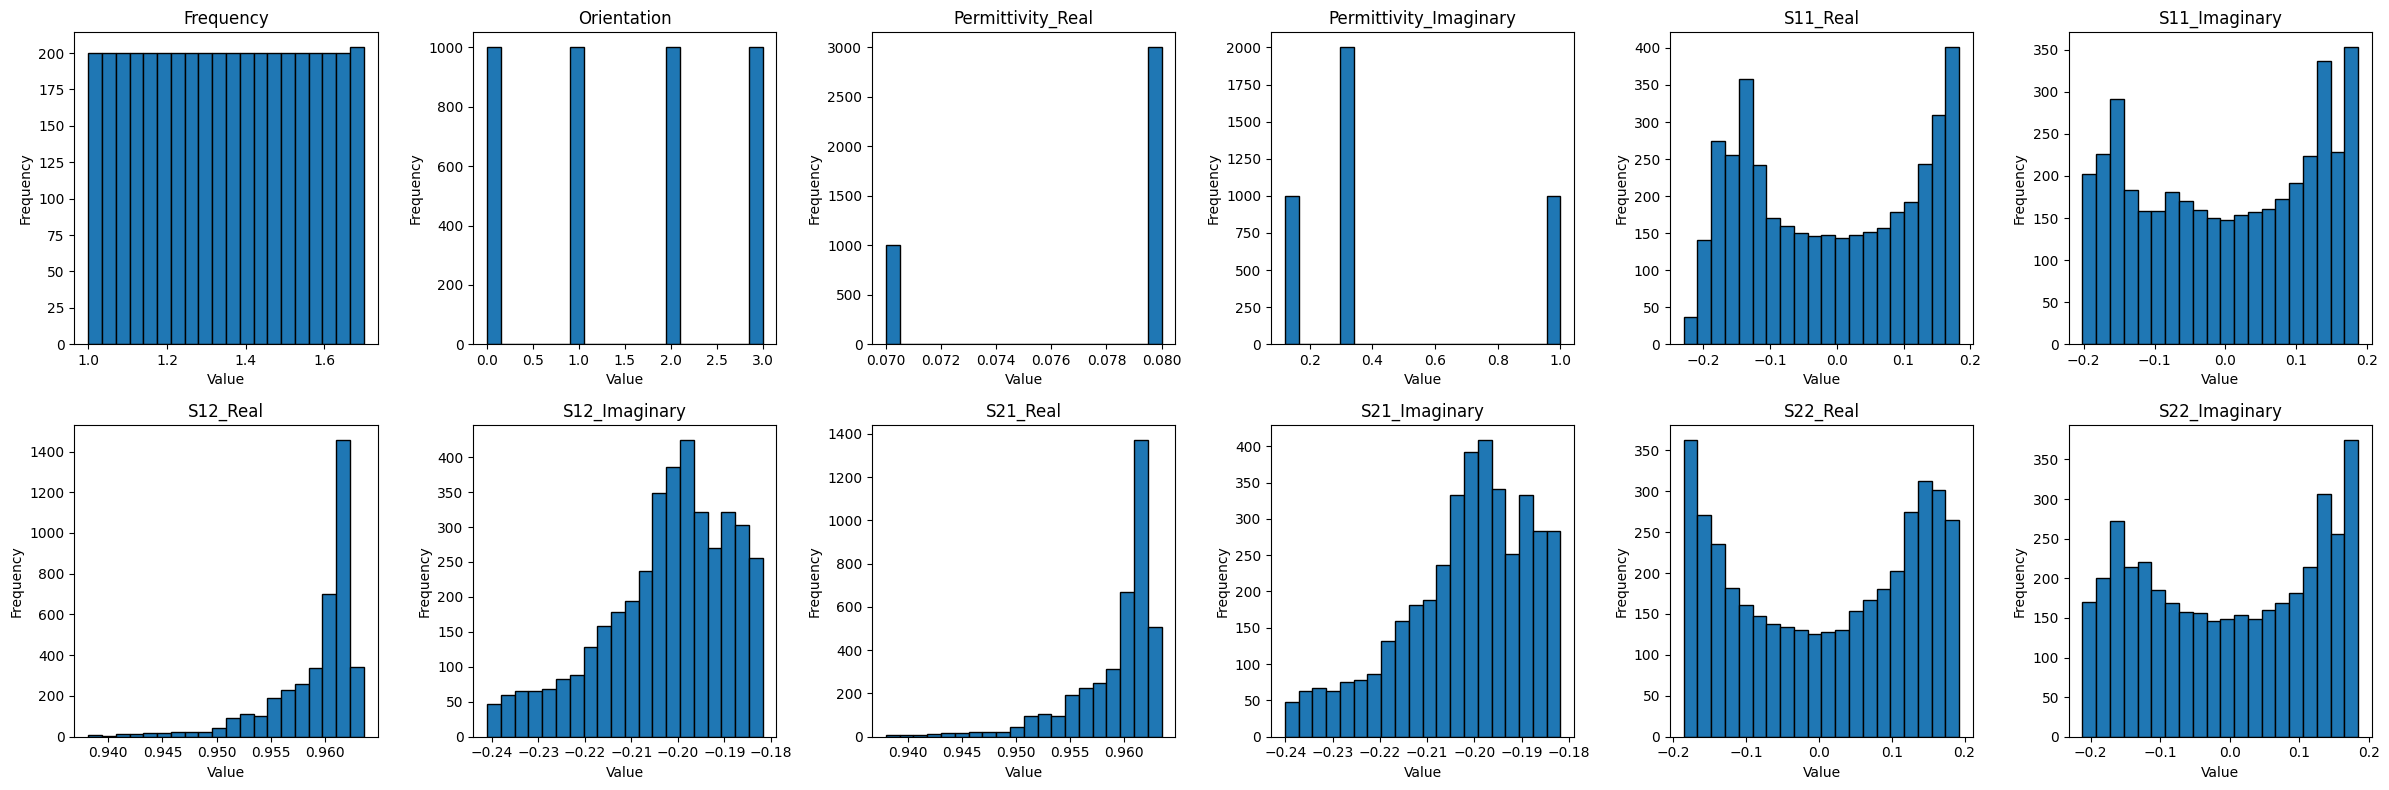

In [490]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [491]:
columns = training_dataframe.columns[3:]
training_mean_predicted_values = training_dataframe.groupby('Frequency')[columns].mean()
testing_mean_predicted_values = testing_dataframe.groupby('Frequency')[columns].mean()

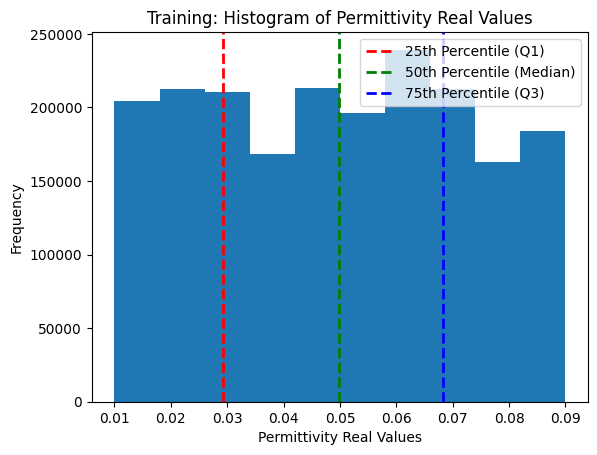

In [492]:
q25 = np.percentile(training_dataframe["Permittivity_Real"], 25)
q50 = np.percentile(training_dataframe["Permittivity_Real"], 50)
q75 = np.percentile(training_dataframe["Permittivity_Real"], 75)
plt.hist(training_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Permittivity Real Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

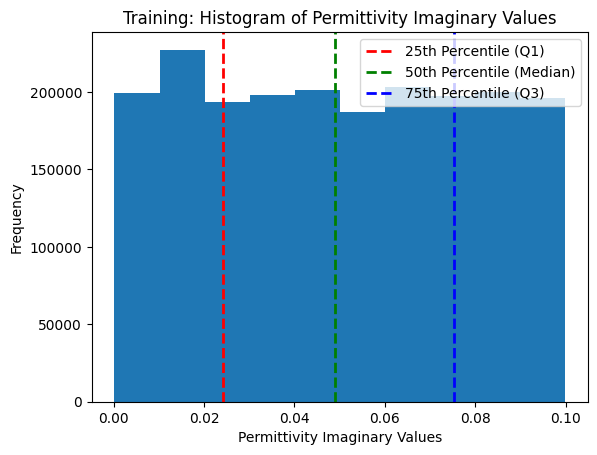

In [493]:
q25 = np.percentile(training_dataframe["Permittivity_Imaginary"], 25)
q50 = np.percentile(training_dataframe["Permittivity_Imaginary"], 50)
q75 = np.percentile(training_dataframe["Permittivity_Imaginary"], 75)
plt.hist(training_dataframe["Permittivity_Imaginary"])
plt.xlabel("Permittivity Imaginary Values")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Permittivity Imaginary Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

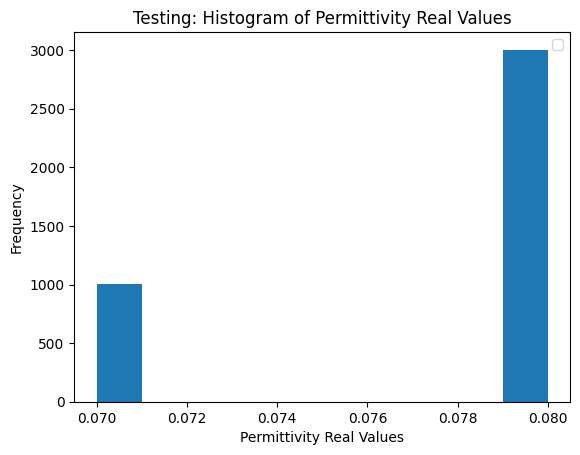

In [494]:
plt.hist(testing_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Real Values")
plt.legend()
plt.show()

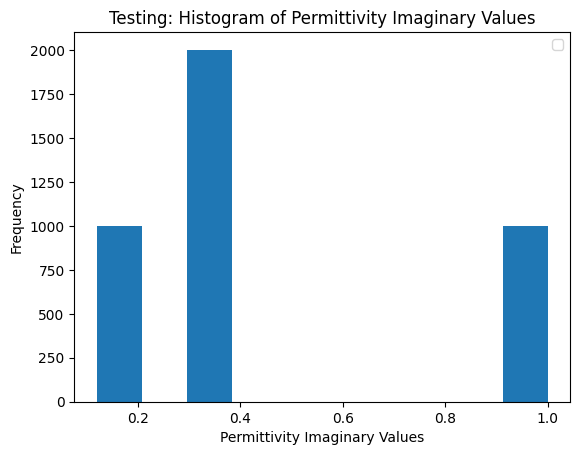

In [495]:
plt.hist(testing_dataframe["Permittivity_Imaginary"])
plt.xlabel("Permittivity Imaginary Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Imaginary Values")
plt.legend()
plt.show()

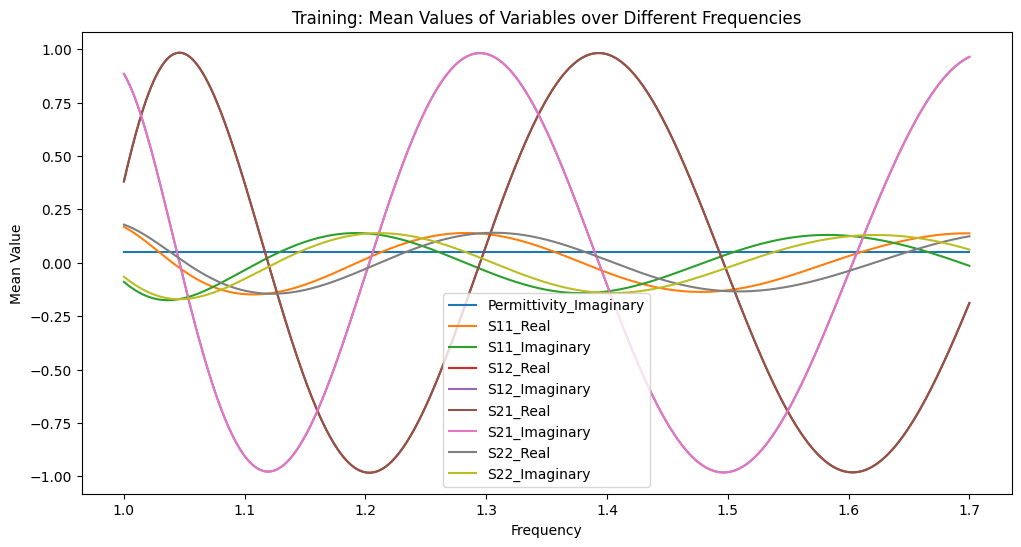

In [496]:
plt.figure(figsize=(12, 6))
for col in training_mean_predicted_values.columns:
    plt.plot(training_mean_predicted_values.index, training_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

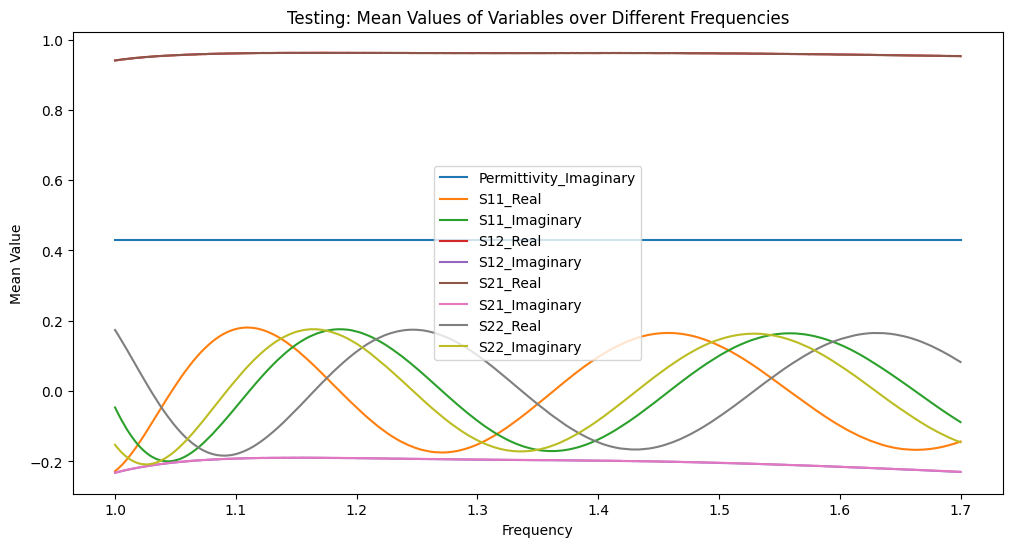

In [497]:
plt.figure(figsize=(12, 6))
for col in testing_mean_predicted_values.columns:
    plt.plot(testing_mean_predicted_values.index, testing_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Testing: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

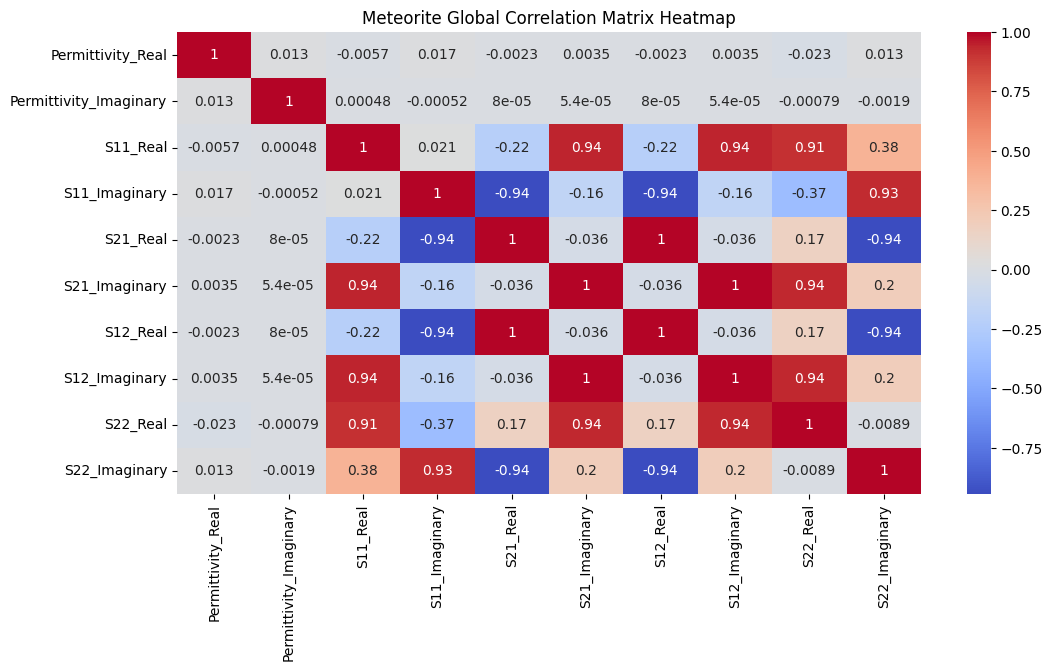

In [498]:
plt.figure(figsize=(12, 6))
sns.heatmap(training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary', 'S11_Real', 'S11_Imaginary', 'S21_Real','S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real','S22_Imaginary']].corr(), annot=True, cmap='coolwarm')
plt.title('Meteorite Global Correlation Matrix Heatmap')
plt.show()

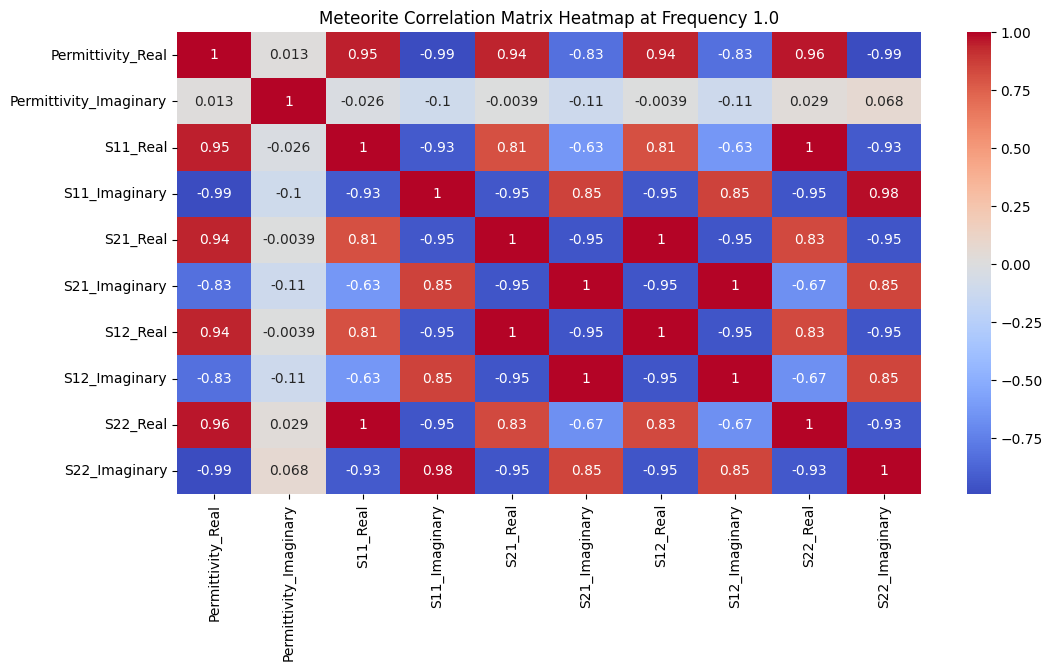

<Figure size 1200x600 with 0 Axes>

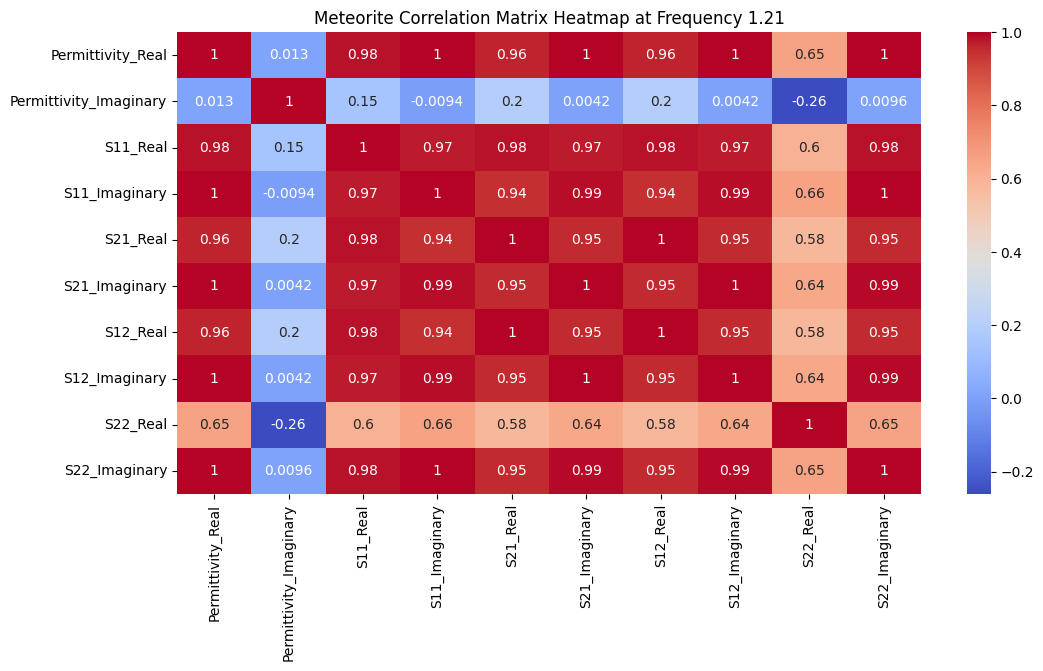

<Figure size 1200x600 with 0 Axes>

In [499]:
unique_frequencies = np.unique(training_dataframe["Frequency"])
count = 0
for i in range(0, len(unique_frequencies), 300):
    if count < 2:
        plt.figure(figsize=(12, 6))
        sample = training_dataframe[training_dataframe["Frequency"] == unique_frequencies[i]]
        sns.heatmap(sample[['Permittivity_Real', 'Permittivity_Imaginary', 'S11_Real', 'S11_Imaginary', 'S21_Real', 'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real', 'S22_Imaginary']].corr(), annot=True, cmap='coolwarm')
        plt.title(f'Meteorite Correlation Matrix Heatmap at Frequency {np.round(unique_frequencies[i],3)}')
        plt.figure(figsize=(12, 6))
        count += 1
    else:
        break

In [500]:
no_id = [
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [501]:
meteorite_non_old_testing = testing_dataframe.copy()
meteorite_non_old_testing_transform = testing_dataframe.copy()
meteorite_non_old_testing_transform[meteorite_non_old_testing_transform[no_id].columns] = bc.transform(meteorite_non_old_testing_transform[no_id])

In [502]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
cb = QuantileTransformer(random_state=42)
cb.fit(training_dataframe[no_id])
training_dataframe[training_dataframe[no_id].columns] = cb.transform(training_dataframe[no_id])
testing_dataframe[testing_dataframe[no_id].columns]  = cb.transform(testing_dataframe[no_id])

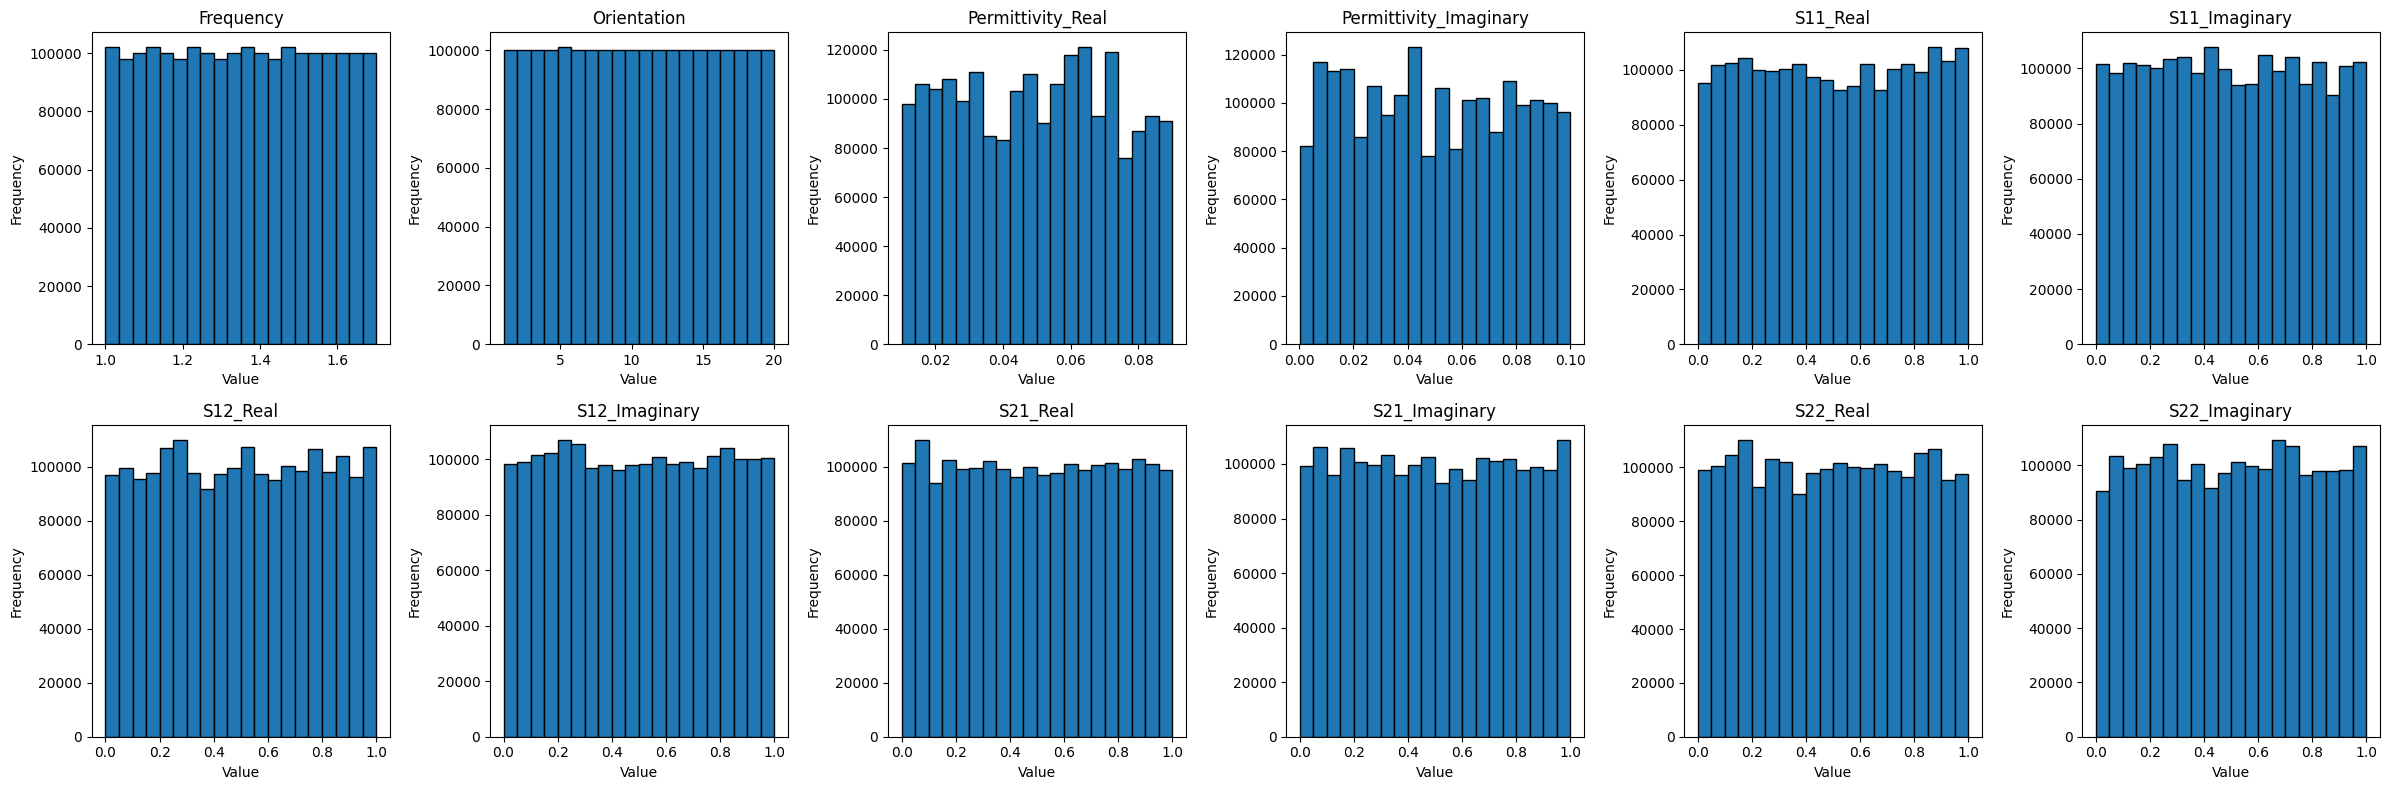

In [503]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

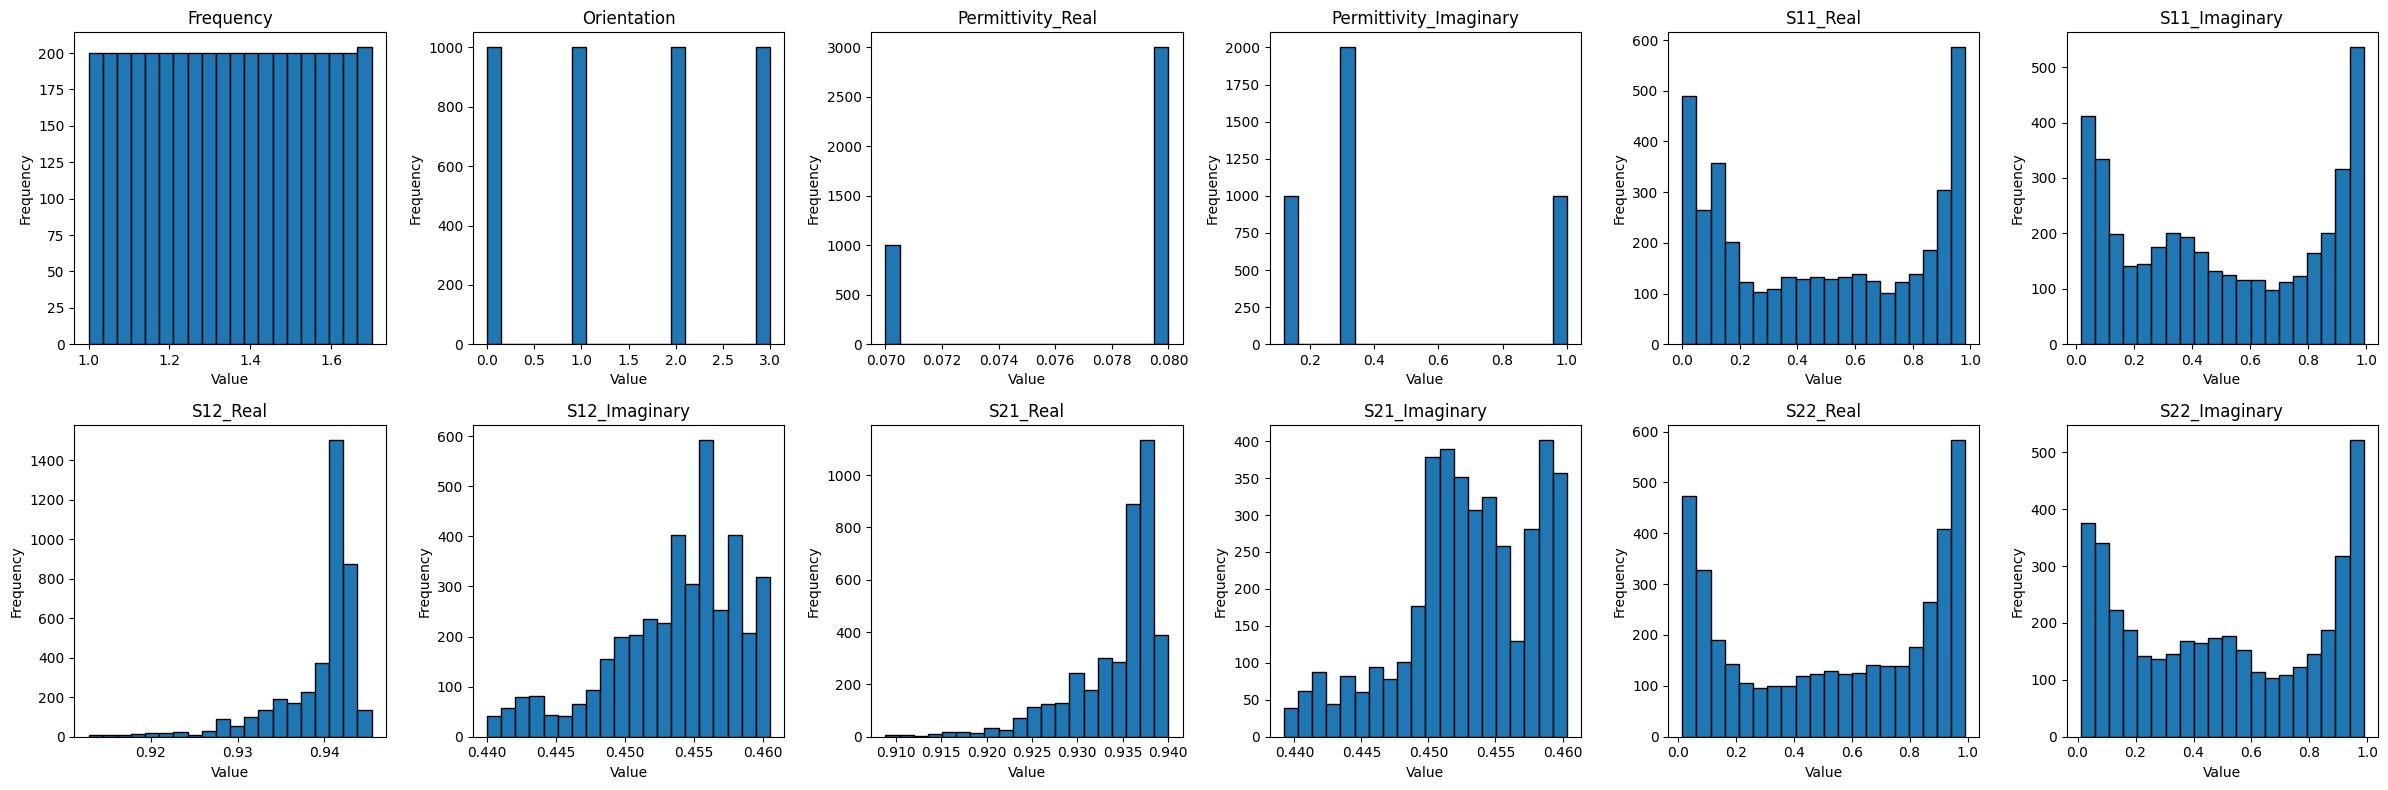

In [504]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [505]:
meteorite_old_testing = testing_dataframe.copy()
meteorite_old_testing_transform = testing_dataframe.copy()
meteorite_old_testing_transform[meteorite_old_testing_transform[no_id].columns] = bc.transform(meteorite_old_testing_transform[no_id])

In [506]:
columns = []
for column in testing_dataframe.columns:
    if column not in ["Permittivity_Real","Permittivity_Imaginary","ID","Orientation","Frequency"]:
        columns.append(column)
columns

['S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

# Feedforward Neural Network Meteorite

In [509]:
models = []

## Learning from Individual Observations without Considering Measurement Order (Randomized)

In [510]:
LR = 0.0001
L2 = 0.0001
WD = 0.000001

In [511]:
columns = []
for column in training_dataframe.columns:
    if column not in ["Permittivity_Real","Permittivity_Imaginary","ID","Orientation","Frequency"]:
        columns.append(column)
columns

['S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [512]:
X_train = training_dataframe[columns].values
y_train = training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
selected_indices = np.random.permutation(len(training_dataframe))
X_selected = X_train[selected_indices]
y_selected = y_train[selected_indices]
grouped_indices = {}
for idx in selected_indices:
    row = training_dataframe.iloc[idx]
    orientation = row['Orientation']
    frequency = row['Frequency']
    key = (orientation, frequency)
    if key not in grouped_indices:
        grouped_indices[key] = []
    grouped_indices[key].append(idx)
X_train_indices = []
X_val_indices = []
X_test_indices = []
for key, indices in grouped_indices.items():
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
    val_indices, test_indices = train_test_split(val_indices, test_size=0.2, random_state=42)
    X_train_indices.extend(train_indices)
    X_val_indices.extend(val_indices)
    X_test_indices.extend(test_indices)
X_train = X_selected[X_train_indices]
y_train = y_selected[X_train_indices]
X_val = X_selected[X_val_indices]
y_val = y_selected[X_val_indices]
X_test_indices.sort()
X_test = X_selected[X_test_indices]
y_test = y_selected[X_test_indices]
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [513]:
num_obs_train = len(X_train)
num_obs_val = len(X_val)
num_obs_test = len(X_test)
total_obs = num_obs_train + num_obs_val + num_obs_test
data = {'Dataset': ['Training', 'Validation', 'Test', 'Total'],
        'Number of Observations': [num_obs_train, num_obs_val, num_obs_test, total_obs]}
observations_table = pd.DataFrame(data)
print(observations_table)

      Dataset  Number of Observations
0    Training                 1601600
1  Validation                  320320
2        Test                   81081
3       Total                 2003001


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               1152      
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 16)                528       
                                                                 
 dense_39 (Dense)            (None, 2)                 34        
                                                                 
Total params: 12050 (47.07 KB)
Trainable params: 12050 (47.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
1600/16

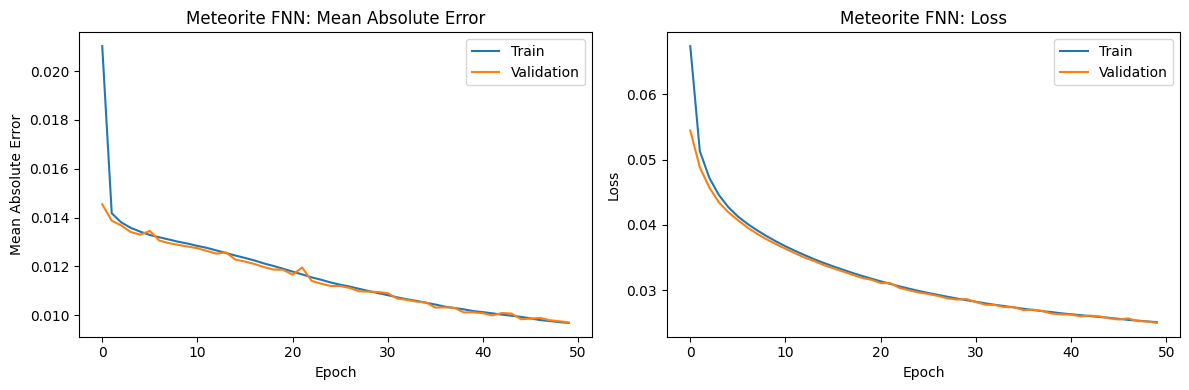

In [514]:
def rmse_loss(y_true, y_pred):
    squared_error = tf.square(y_true - y_pred)
    mean_squared_error = tf.reduce_mean(squared_error)
    root_mean_squared_error = tf.sqrt(mean_squared_error)
    return root_mean_squared_error

ind_no_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(16, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(y_train.shape[1], activation='linear')
])


ind_no_model.compile(optimizer=tf.optimizers.Adam(learning_rate=L2,weight_decay=WD),
              loss=[rmse_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
ind_no_model.summary()
history = ind_no_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1001,shuffle=True)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Meteorite FNN: Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Meteorite FNN: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

In [515]:
xgb_model = xgb.XGBRegressor(n_jobs=-1,device="gpu",n_estimators=250,eval_metric=mean_absolute_error,verbosity=3,max_depth=5)
xgb_model.fit(X_train, y_train)

[06:44:07] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[06:44:07] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[06:44:09] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[06:44:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[06:44:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[06:44:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[06:44:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[06:44:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[06:44:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[06:44:17] INFO: ../src/tree/updater_prune.cc:98: tree pruning end

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7de5cce471c0>,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=250, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

In [516]:
batch_size = 1001
y_pred_no = ind_no_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_no = y_pred_no.reshape(-1, batch_size, y_pred_no.shape[-1])
y_pred_xgb = y_pred_xgb.reshape(-1, batch_size, y_pred_xgb.shape[-1])
y_test = y_test.reshape(-1, batch_size, y_test.shape[-1])
y_pred_no = np.mean(y_pred_no, axis=1)
y_pred_xgb = np.mean(y_pred_xgb, axis=1)
y_test = np.mean(y_test, axis=1)
y_pred_0_no, y_test_0 = y_pred_no[:, 0], y_test[:, 0]
y_pred_1_no, y_test_1 = y_pred_no[:, 1], y_test[:, 1]
y_pred_0_xgb, _ = y_pred_xgb[:, 0], _
y_pred_1_xgb, _ = y_pred_xgb[:, 1], _
y_pred_0_no = np.clip(y_pred_0_no, 0.0, 0.2)
y_pred_1_no = np.clip(y_pred_1_no, 0.0, 0.2)
y_pred_0_xgb = np.clip(y_pred_0_xgb, 0.0, 0.2)
y_pred_1_xgb = np.clip(y_pred_1_xgb, 0.0, 0.2)

2534/2534 [==============================] - 11s 4ms/step


In [517]:
mse_xgb = mean_squared_error(y_test_0, y_pred_0_xgb)
mae_xgb = mean_absolute_error(y_test_0, y_pred_0_xgb)
r_squared_xgb = r2_score(y_test_0, y_pred_0_xgb)
mse_no = mean_squared_error(y_test_0, y_pred_0_no)
mae_no = mean_absolute_error(y_test_0, y_pred_0_no)
r_squared_no = r2_score(y_test_0, y_pred_0_no)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_no:.4f}")
print(f"MAE: {mae_no:.4f}")
print(f"R-squared (R²): {r_squared_no:.4f}")

Metrics for XGBoost Model:
MSE: 0.0000
MAE: 0.0001
R-squared (R²): 0.9641

Metrics for FNN Model:
MSE: 0.0000
MAE: 0.0008
R-squared (R²): -0.3374


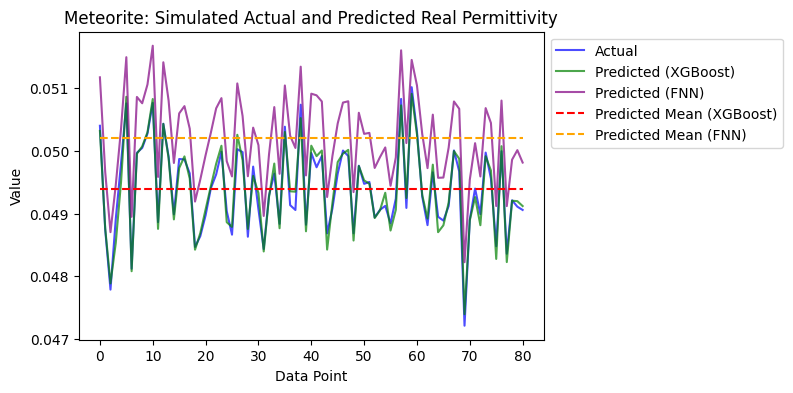

In [518]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_0)), y_test_0, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_no, label='Predicted (FNN)', color='purple', alpha=0.7)
plt.plot([0, len(y_test_0) - 1], [np.mean(y_pred_0_xgb), np.mean(y_pred_0_xgb)], linestyle='dashed', color='red', label='Predicted Mean (XGBoost)')
plt.plot([0, len(y_test_0) - 1], [np.mean(y_pred_0_no), np.mean(y_pred_0_no)], linestyle='dashed', color='orange', label='Predicted Mean (FNN)')
plt.title('Meteorite: Simulated Actual and Predicted Real Permittivity')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [519]:
mse_xgb = mean_squared_error(y_test_1, y_pred_1_xgb)
mae_xgb = mean_absolute_error(y_test_1, y_pred_1_xgb)
r_squared_xgb = r2_score(y_test_1, y_pred_1_xgb)
mse_no = mean_squared_error(y_test_1, y_pred_1_no)
mae_no = mean_absolute_error(y_test_1, y_pred_1_no)
r_squared_no = r2_score(y_test_1, y_pred_1_no)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_no:.4f}")
print(f"MAE: {mae_no:.4f}")
print(f"R-squared (R²): {r_squared_no:.4f}")

Metrics for XGBoost Model:
MSE: 0.0000
MAE: 0.0007
R-squared (R²): 0.3828

Metrics for FNN Model:
MSE: 0.0000
MAE: 0.0027
R-squared (R²): -6.5300


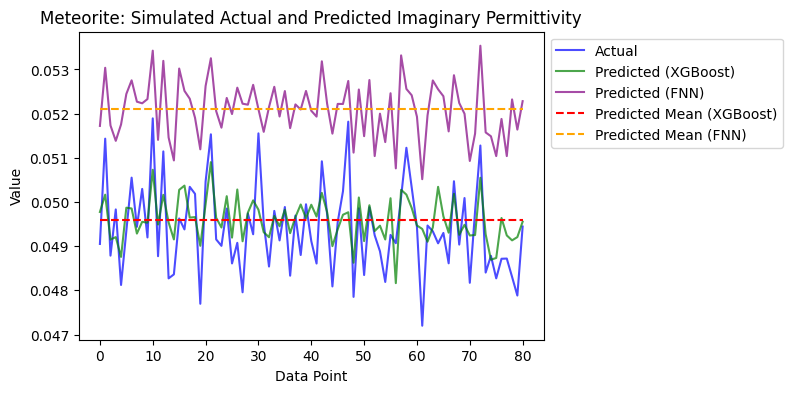

In [520]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_1)), y_test_1, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_no, label='Predicted (FNN)', color='purple', alpha=0.7)
plt.plot([0, len(y_test_1) - 1], [np.mean(y_pred_1_xgb), np.mean(y_pred_1_xgb)], linestyle='dashed', color='red', label='Predicted Mean (XGBoost)')
plt.plot([0, len(y_test_1) - 1], [np.mean(y_pred_1_no), np.mean(y_pred_1_no)], linestyle='dashed', color='orange', label='Predicted Mean (FNN)')
plt.title('Meteorite: Simulated Actual and Predicted Imaginary Permittivity')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [543]:
X_test = testing_dataframe[columns].values
y_test = testing_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
X_test = X_test.astype(float)
y_test = y_test.astype(float)
batch_size = 1001
y_pred_no = ind_no_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_no = y_pred_no.reshape(-1, batch_size, y_pred_no.shape[-1])
y_pred_xgb = y_pred_xgb.reshape(-1, batch_size, y_pred_xgb.shape[-1])
y_test = y_test.reshape(-1, batch_size, y_test.shape[-1])
y_pred_no = np.mean(y_pred_no, axis=1)
y_pred_xgb = np.mean(y_pred_xgb, axis=1)
y_test = np.mean(y_test, axis=1)
y_pred_0_no, y_test_0 = y_pred_no[:, 0], y_test[:, 0]
y_pred_1_no, y_test_1 = y_pred_no[:, 1], y_test[:, 1]
y_pred_0_xgb, _ = y_pred_xgb[:, 0], _
y_pred_1_xgb, _ = y_pred_xgb[:, 1], _
y_pred_0_no = np.clip(y_pred_0_no, 0.0, 0.2)
y_pred_1_no = np.clip(y_pred_1_no, 0.0, 0.2)
y_pred_0_xgb = np.clip(y_pred_0_xgb, 0.0, 0.2)
y_pred_1_xgb = np.clip(y_pred_1_xgb, 0.0, 0.2)

126/126 [==============================] - 0s 1ms/step


In [522]:
num_obs_test = len(X_test)
data = {'Dataset': [ 'Test'],
        'Number of Observations': [num_obs_test]}
observations_table = pd.DataFrame(data)
print(observations_table)

  Dataset  Number of Observations
0    Test                    4004


In [523]:
mse_xgb = mean_squared_error(y_test_0, y_pred_0_xgb)
mae_xgb = mean_absolute_error(y_test_0, y_pred_0_xgb)
r_squared_xgb = r2_score(y_test_0, y_pred_0_xgb)
mse_no = mean_squared_error(y_test_0, y_pred_0_no)
mae_no = mean_absolute_error(y_test_0, y_pred_0_no)
r_squared_no = r2_score(y_test_0, y_pred_0_no)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_no:.4f}")
print(f"MAE: {mae_no:.4f}")
print(f"R-squared (R²): {r_squared_no:.4f}")

Metrics for XGBoost Model:
MSE: 0.0001
MAE: 0.0076
R-squared (R²): -2.3709

Metrics for FNN Model:
MSE: 0.0006
MAE: 0.0235
R-squared (R²): -29.2599


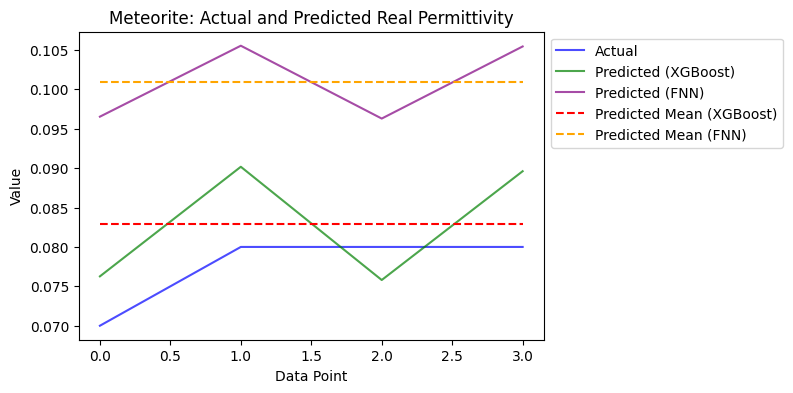

In [524]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_0)), y_test_0, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_no, label='Predicted (FNN)', color='purple', alpha=0.7)
plt.plot([0, len(y_test_0) - 1], [np.mean(y_pred_0_xgb), np.mean(y_pred_0_xgb)], linestyle='dashed', color='red', label='Predicted Mean (XGBoost)')
plt.plot([0, len(y_test_0) - 1], [np.mean(y_pred_0_no), np.mean(y_pred_0_no)], linestyle='dashed', color='orange', label='Predicted Mean (FNN)')
plt.title('Meteorite: Actual and Predicted Real Permittivity')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [525]:
mse_xgb = mean_squared_error(y_test_1, y_pred_1_xgb)
mae_xgb = mean_absolute_error(y_test_1, y_pred_1_xgb)
r_squared_xgb = r2_score(y_test_1, y_pred_1_xgb)
mse_no = mean_squared_error(y_test_1, y_pred_1_no)
mae_no = mean_absolute_error(y_test_1, y_pred_1_no)
r_squared_no = r2_score(y_test_1, y_pred_1_no)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_no:.4f}")
print(f"MAE: {mae_no:.4f}")
print(f"R-squared (R²): {r_squared_no:.4f}")

Metrics for XGBoost Model:
MSE: 0.1666
MAE: 0.2700
R-squared (R²): -0.4653

Metrics for FNN Model:
MSE: 0.2335
MAE: 0.3468
R-squared (R²): -1.0534


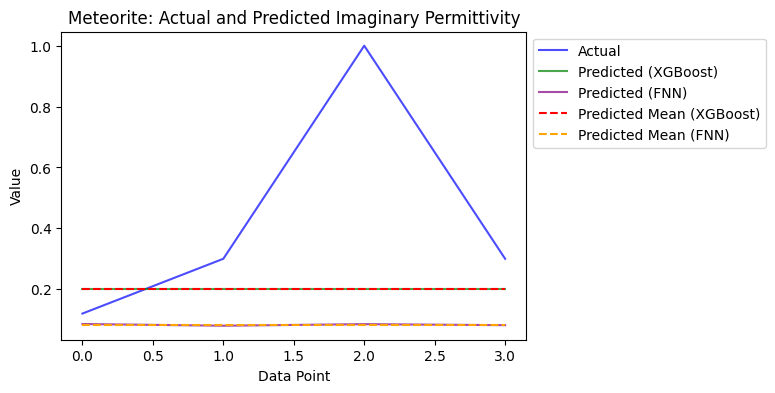

In [526]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_1)), y_test_1, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_no, label='Predicted (FNN)', color='purple', alpha=0.7)
plt.plot([0, len(y_test_1) - 1], [np.mean(y_pred_1_xgb), np.mean(y_pred_1_xgb)], linestyle='dashed', color='red', label='Predicted Mean (XGBoost)')
plt.plot([0, len(y_test_1) - 1], [np.mean(y_pred_1_no), np.mean(y_pred_1_no)], linestyle='dashed', color='orange', label='Predicted Mean (FNN)')
plt.title('Meteorite: Actual and Predicted Imaginary Permittivity')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()